# Zero Shot Super Resolution (ZSSR)
In this notebook you will solve the challenge of single image super-resolution. In this challenge, given a low-resolution image you are required to predict a high-resolution version of it without any additional information. In order to solve this challenge, you will implement a simplified version of the method proposed by Shocher et al. in the paper [Zero-Shot Super Resolution using Deep Internal Learning](http://www.weizmann.ac.il/math/irani/sites/math.irani/files/uploads/zssr_cameraready.pdf) (abbrv. ZSSR). You are highly encouraged to read the paper to gain an in depth understanding of the homework's task.


## Deep Super Resolution
There are a few naive solutions for the Super Resolution task that involve classic Computer Vision Methods - [this link](https://en.wikipedia.org/wiki/Comparison_gallery_of_image_scaling_algorithms) provides a short survey of them.
With the emergence of Deep Learning in Computer Vision, new solutions for the Super Resolution task were invented (e.g. [ESRGAN](https://arxiv.org/pdf/1809.00219.pdf)). Most of these solutions introduce Convolutional Neural Networks that are trained on a large dataset to perform Super Resolution on any image.

<img src="https://drive.google.com/uc?export=view&id=1zXOsbFv8UBVZID-XnKnTPgQq12EjmRxO" alt="standard deep superresolution" width="500">


## ZSSR

With contrast to former works, the authors of ZSSR propose training an individual CNN **for each image during test time**. They leverage the fact that fully convolutional networks can be applied to varying spatial shapes of inputs. In fact, fully convolutional networks are actually trained on image patches of the networks receptive field's size. [Glasner et al.](http://www.wisdom.weizmann.ac.il/~vision/courses/2010_2/papers/single_image_SR.pdf) show that patches recurr accross scales in natural images. Therefore, a network trained to perform super-resolution from shape $(H/2, W/2)$ to $(H, W)$ can in fact be used to perform super-resolution from shape $(H, W)$ to $(2 \cdot H, 2 \cdot W)$. The network learns to perform super-resolution on patches in specific scales, but can be used for inference over and over due to the patch recurrence across scales. This phenomena is used as self-supervision in this framework.

The framework follows these steps:
1. Let $I$ be our input image.
2. Get $LR(I)$, a low resolution version of $I$ using the downscaling operation $LR(.)$ of some scale factor $s$.
3. Pass $LR(I)$ through a CNN $f_\theta$ where $f$ is the network's architecture and $\theta$ are the network's weights.
4. $f_\theta$ produces a super resolution of $I$ - $SR(LR(I))$ of the same shape as the original image $I$. In other words, $f_\theta$ learns to upscale the image by the scale factor $s$.
5. $f_\theta$ is trained to produce images identical to the original image $I$, using the $L_1$ reconstruction loss between $SR(LR(I))$ and $I$.

<img src="https://drive.google.com/uc?export=view&id=1IEHf9mibOiYWEAITrg1dRy4XR8wBO4Tb" alt="zssr_3" width="500">

6. $f_\theta$ is applied on $I$ and outputs $SR(I)$ - the upscaled version of $I$.

<img src="https://drive.google.com/uc?export=view&id=13kSEQneeHm0225kRgmnoHWTytx7E2voM" alt="zssr_4" width="350">

Due to patch recurrence across scales, this process can be applied in a repetative manner and provide us any super resolution of $I$ of size $t \cdot s$ where $t$ is the number of times we passed the input through $f_\theta$.

**NOTE:** Methods that use examples from a single image alone are coined as *Deep Internal Learning*.

**NOTE:** Notice this work implicitly sets a bias - all SR images are bicubic interpolations of the LR images. This is not the case in real world examples. Some follow up works (e.g. [Bell-Kligler et al.](https://proceedings.neurips.cc/paper/2019/file/5fd0b37cd7dbbb00f97ba6ce92bf5add-Paper.pdf)) introduce solutions to this.

By this point you should have some general understanding of the ZSSR framework.


In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Step 1: Import libraries**

In [ ]:
import os
from PIL import Image

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

In [ ]:
import utils

In [ ]:
!ls gdrive/MyDrive/PracticalDL/Final-Project/images_train # 10 images for zero-shot learning

cheetah_1.jpg  cheetah_3.jpg  cheetah_5.jpg  lion_2.jpg  lion_4.jpg
cheetah_2.jpg  cheetah_4.jpg  lion_1.jpg     lion_3.jpg  lion_5.jpg


**Step 2: Images loading**

In [ ]:
#Getting the directory with images for train
images_train_path = 'gdrive/MyDrive/PracticalDL/Final-Project/images_train'
img_names_train = sorted(os.listdir(images_train_path))
img_path_train = [os.path.join(images_train_path, im) for im in img_names_train]

In [ ]:
from data_handling import ZSSRDataset
from data_handling import advanced_trans

In [ ]:
#defining transform
transform = advanced_trans()

In [ ]:
scale_factor = 2
dataset_train = ZSSRDataset(img_path_train,
                            scale_factor=scale_factor,
                            transform=transform)

In [ ]:
dataloader_train = DataLoader(dataset_train)

Train dataset
sr_img size:  torch.Size([1, 4, 3, 324, 512])
lr_img size:  torch.Size([1, 4, 3, 162, 256])


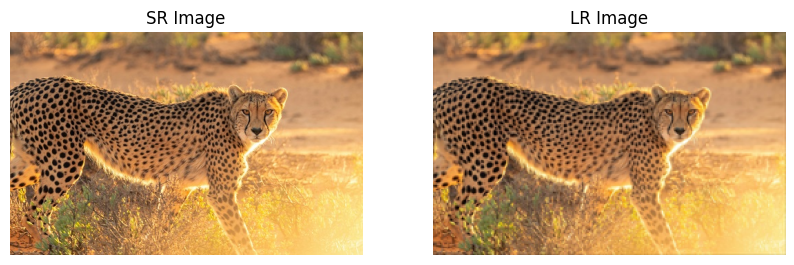

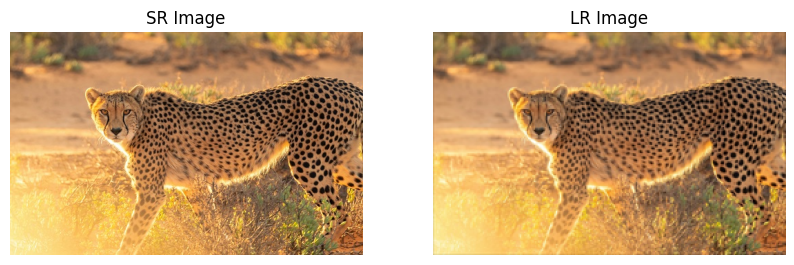

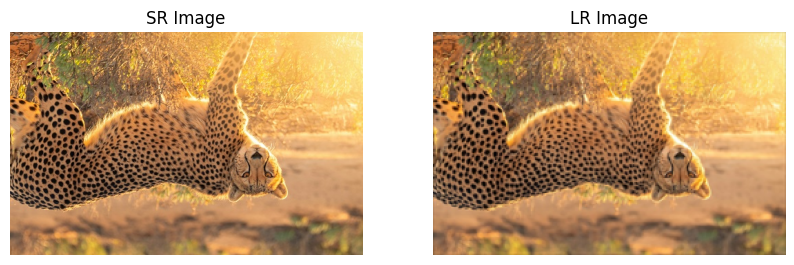

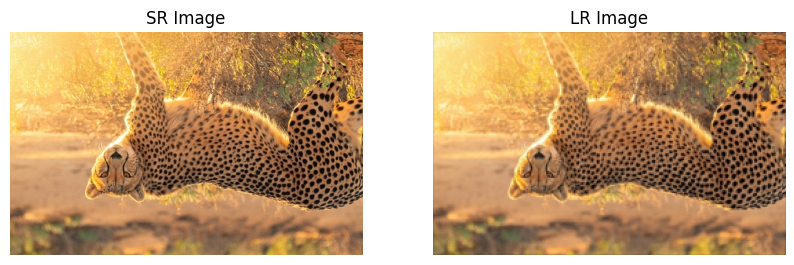

In [ ]:
#Drawing example for train
for image_ex in dataloader_train:
  sr_img = image_ex['SR']
  lr_img = image_ex['LR']

  print('Train dataset')
  print('sr_img size: ', sr_img.size())
  print('lr_img size: ', lr_img.size())

  sr_img =sr_img.squeeze(0)
  lr_img = lr_img.squeeze(0)

  for i in range(len(sr_img)):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Display SR image
        axes[0].imshow(sr_img[i].permute(1, 2, 0))
        axes[0].set_title('SR Image')
        axes[0].axis('off')

        # Display LR image
        axes[1].imshow(lr_img[i].permute(1, 2, 0))
        axes[1].set_title('LR Image')
        axes[1].axis('off')

        plt.show()

  break

**test images loading**

In [ ]:
#Getting the directory with images for test
images_test_path = 'gdrive/MyDrive/PracticalDL/Final-Project/images_test'
img_names_test = sorted(os.listdir(images_test_path))
img_path_test = [os.path.join(images_test_path, im) for im in img_names_test]

In [ ]:
dataset_test = ZSSRDataset(img_path_test)
dataloader_test = DataLoader(dataset_test)

Train dataset
sr_img size:  torch.Size([1, 3, 1600, 2560])
lr_img size:  torch.Size([1, 3, 800, 1280])


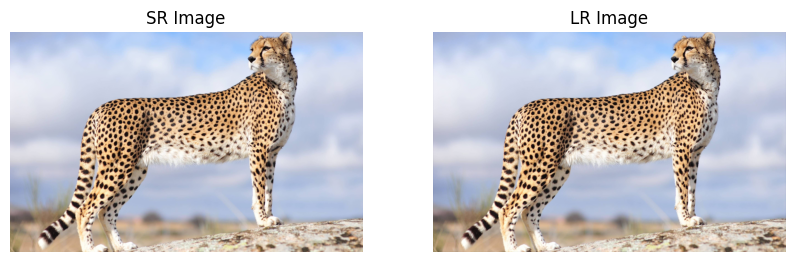

In [ ]:
#Drawing example for test
for image_ex in dataloader_test:
  sr_img = image_ex['SR']
  lr_img = image_ex['LR']

  print('Train dataset')
  print('sr_img size: ', sr_img.size())
  print('lr_img size: ', lr_img.size())

  sr_img =sr_img.squeeze(0)
  lr_img = lr_img.squeeze(0)

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  # Display SR image
  axes[0].imshow(sr_img.permute(1, 2, 0))
  axes[0].set_title('SR Image')
  axes[0].axis('off')

  # Display LR image
  axes[1].imshow(lr_img.permute(1, 2, 0))
  axes[1].set_title('LR Image')
  axes[1].axis('off')

  plt.show()



  break

***Step 3: Model implementation***

In [ ]:
from models import ZSSRResNet

In [ ]:
#model params
device = 'cuda' if torch.cuda.is_available() else 'cpu'
verbose = True
lr = 0.001
epochs = 300
show_interval = 10
scale_factor=2

In [ ]:
#Define model
model = ZSSRResNet(scale_factor=scale_factor)
print(device)
model.to(device=device)

cuda


ZSSRResNet(
  (layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1-6): 6 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (output): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = torch.nn.L1Loss()

In [ ]:
best_psnr = 0

train_losses = []
train_psnrs = []
test_psnrs = []

num_train_batches = len(dataloader_train)
num_test_batches = len(dataloader_test)

for epoch in tqdm(range(1, epochs + 1)):
  train_loss, train_psnr = 0, 0

  for data_train in dataloader_train:
    SR_image, LR_image = data_train['SR'].to(device), data_train['LR'].to(device)

    SR_image = SR_image.squeeze(0)
    LR_image = LR_image.squeeze(0)

    outputs = model(LR_image)

    loss = criterion(outputs, SR_image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    #psnr on original unrotated image (index 0)
    train_psnr += utils.psnr(outputs[0], SR_image[0])

  train_losses.append(train_loss)
  avg_train_psnr = train_psnr.item() / num_train_batches
  train_psnrs.append(avg_train_psnr)

  if epoch % show_interval == 0:
    test_psnr = 0
    with torch.no_grad():
      for data_test in dataloader_test:
        sr_image_test, lr_image_test = data_test['SR'].to(device=device), data_test['LR'].to(device=device)
        created_image = model(lr_image_test)
        test_psnr += utils.psnr(created_image[0], sr_image_test[0])

      avg_test_psnr = test_psnr.item() / num_test_batches
      test_psnrs.append(avg_test_psnr)
      if avg_test_psnr > best_psnr:
        best_psnr = avg_test_psnr
        torch.save(model.state_dict(), 'best_ZSSR_model.pth')


100%|██████████| 300/300 [10:44<00:00,  2.15s/it]


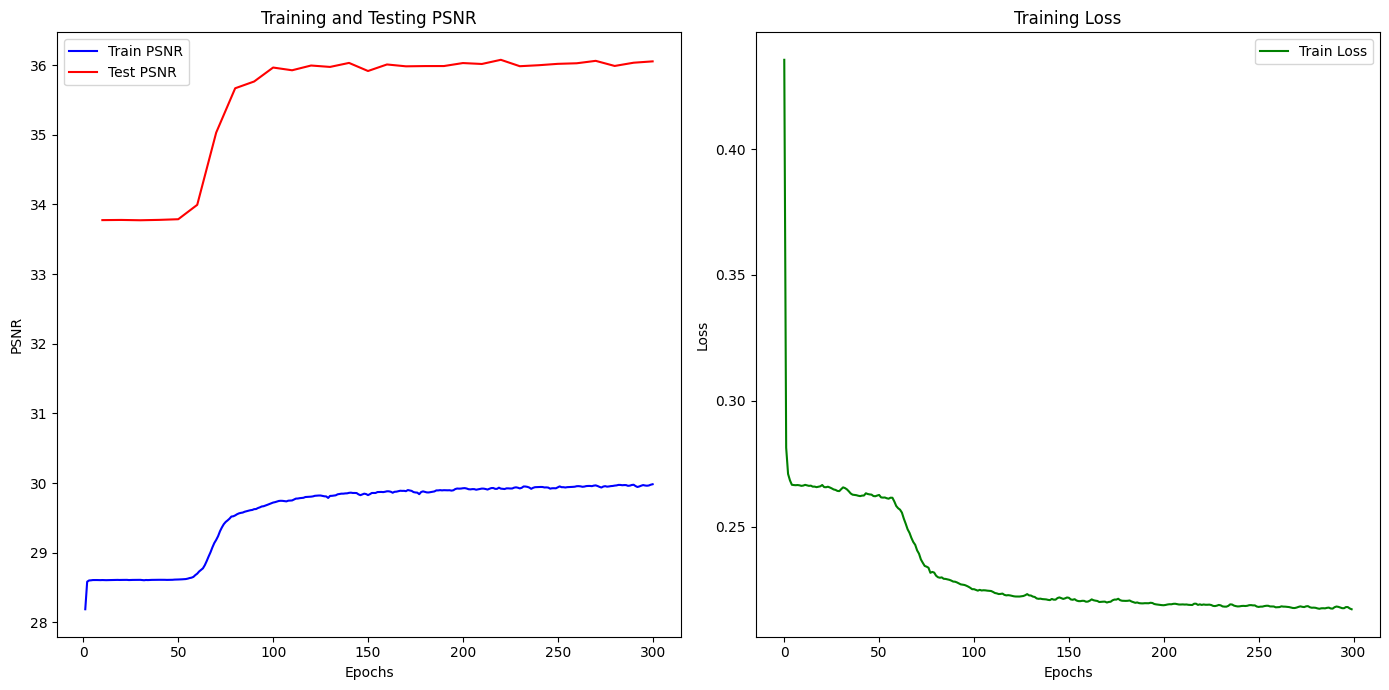

In [ ]:
plt.figure(figsize=(14, 7))

# Plot the PSNRs
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, epochs + 1), train_psnrs, label='Train PSNR', color='blue')
plt.plot(np.arange(show_interval, epochs + 1, show_interval), test_psnrs, label='Test PSNR', color='red')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.title('Training and Testing PSNR')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
best_psnr

36.07747268676758

Applying the model to video frames

In [ ]:
import cv2

In [ ]:
def split_video_to_frames(video_path, output_folder):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Capture the video
    video_capture = cv2.VideoCapture(video_path)
    success, image = video_capture.read()
    count = 0

    while success:
        # Save frame as image
        frame_filename = os.path.join(output_folder, f"frame{count:04d}.jpg")
        cv2.imwrite(frame_filename, image)

        # Read the next frame
        success, image = video_capture.read()
        count += 1

    video_capture.release()
    print(f"Extracted {count} frames to '{output_folder}'")

In [ ]:
!ls gdrive/MyDrive/PracticalDL/Final-Project/initial_video

initial-video_360p_1min.mp4  initial-video_720p_1min.mp4


Loading frames from LR video

In [ ]:
video_folder = 'gdrive/MyDrive/PracticalDL/Final-Project/initial_video'
video_name_360 = 'initial-video_360p_1min.mp4'

In [ ]:
video_path_360 = os.path.join(video_folder, video_name_360)
video_path_360

'gdrive/MyDrive/PracticalDL/Final-Project/initial_video/initial-video_360p_1min.mp4'

In [ ]:
output_folder_360 = 'frames_360p'
split_video_to_frames(video_path_360, output_folder_360)

Extracted 780 frames to 'frames_360p'


In [ ]:
frames_360 = os.listdir(output_folder_360)

Loading frames from SR video

In [ ]:
video_name_720 = 'initial-video_720p_1min.mp4'

In [ ]:
video_path_720 = os.path.join(video_folder, video_name_720)
video_path_720

'gdrive/MyDrive/PracticalDL/Final-Project/initial_video/initial-video_720p_1min.mp4'

In [ ]:
output_folder_720 = 'frames_720p'
split_video_to_frames(video_path_720, output_folder_720)

Extracted 780 frames to 'frames_720p'


In [ ]:
frames_720 = os.listdir(output_folder_720)

In [ ]:
low_res_frames_path = [os.path.join('frames_360p', frame) for frame in frames_360]
high_res_frames_path = [os.path.join('frames_720p', frame) for frame in frames_720]

In [ ]:
# Last seconds of video. 0:49 - 1:04
low_res_frames_path_val = low_res_frames_path[588:768]
high_res_frames_path_val = high_res_frames_path[588:768]

To apply this model to video frames, it is necessary to make some modifications to our Dataset

In [ ]:
def load_image(file_path):
    # Open the image file
    with Image.open(file_path) as img:
        # Convert the image to RGB if it's not in that mode
        img = img.convert('RGB')
        return img

In [ ]:
class ZSSRVideoDataset(Dataset):
    def __init__(self, img_path_lr, img_path_sr, transform=transforms.ToTensor()):
        self.img_path_lr = img_path_lr
        self.img_path_sr = img_path_sr
        self.transform = transform

    def __len__(self):
        return len(self.img_path_lr)

    def __getitem__(self, idx):
        img_lr = load_image(self.img_path_lr[idx])
        img_lr = self.transform(img_lr)

        img_sr = load_image(self.img_path_sr[idx])
        img_sr = self.transform(img_sr)

        return {"SR": img_sr, "LR": img_lr}

In [ ]:
dataset_val = ZSSRVideoDataset(
    img_path_lr=low_res_frames_path_val,
    img_path_sr=high_res_frames_path_val
)
dataloader_val = DataLoader(dataset_val)

In [ ]:
from models import ZSSRResNet

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
model = ZSSRResNet(scale_factor=2)
model.load_state_dict(torch.load('best_ZSSR_model.pth'))
model = model.to(device=device)

In [ ]:
num_val_batches = len(dataloader_val)
val_psnr = 0

with torch.no_grad():
  for data_val in dataloader_val:
    sr_image_val, lr_image_val = data_val['SR'].to(device=device), data_val['LR'].to(device=device)
    created_image = model(lr_image_val)
    val_psnr += utils.psnr(created_image[0], sr_image_val[0])

avg_val_psnr = val_psnr.item() / num_val_batches
print('PSNR on real data: ', avg_val_psnr)

PSNR on real data:  38.94647081163195
